<a href="https://colab.research.google.com/github/Ayush245101/IndustryGPT-Specialized-LLM-Bot-Using-Pre-Trained-Models/blob/main/IndustryGPT_Specialized_LLM_Bot_Using_Pre_Trained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Summary -**

This project focuses on building a domain-specific AI chatbot for e-commerce customer support by fine-tuning the T5 transformer model and deploying it via a lightweight web interface using Streamlit and ngrok. The aim is to provide quick, automated, and accurate responses to frequently asked customer queries such as order tracking, delivery options, return/exchange policies, and payment methods.

The chatbot is based on the t5-small model from HuggingFace Transformers, which is known for its text-to-text generation capability. It is trained on a custom dataset tailored specifically for customer service scenarios. The dataset is structured with input prompts in the format "User: <question>\nBot:" and the corresponding expected response. This ensures the model learns not just the content but the conversational structure required for role-based interactions.

To prepare the dataset, each example was tokenized using the T5 tokenizer with padding and truncation applied to standardize input lengths. The preprocessing logic was carefully designed to avoid repetition of prefixes such as "prompt:" to maintain clarity in the training data. The fine-tuning was conducted using the HuggingFace Trainer API within Google Colab. Key hyperparameters such as the number of training epochs (set to 50) and learning rate (1e-4) were adjusted to improve model convergence and response quality.

During evaluation, the model initially faced challenges such as blank or irrelevant responses. These issues were resolved by refining the prompt structure, increasing the number of training epochs, and removing unsupported generation parameters like temperature and top_p for greedy decoding. After fine-tuning, the model showed improved performance and was able to generate relevant and fluent answers to various test inputs from the e-commerce domain.

For deployment, a Streamlit-based web interface was developed that allows users to interact with the chatbot in real-time. The app takes user input, processes it through the fine-tuned model, and displays the response immediately. Since Google Colab does not support web hosting, pyngrok was integrated to create a secure public tunnel that exposes the Streamlit app to the internet. This setup enables full interaction with the chatbot from any device without requiring backend hosting infrastructure.

The final application provides a functional prototype of an AI assistant capable of handling routine customer queries. It has potential real-world applications in small to medium-sized e-commerce platforms where human customer service may be limited. Future enhancements could include multilingual support, intent classification, user history tracking, and integration with real databases for dynamic responses.

In summary, this project demonstrates how transformer-based NLP models can be effectively fine-tuned for narrow domains and deployed using accessible tools like Streamlit and Google Colab. It offers a practical, scalable, and cost-efficient solution to enhance customer service through automation.



# **GitHub Link -**

In [1]:
!pip install transformers datasets sentencepiece
print("✅ Done! Now manually click: Runtime > Restart runtime")

✅ Done! Now manually click: Runtime > Restart runtime


In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import numpy as np
import torch

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Read the uploaded CSV
df = pd.read_csv("/content/data (1).csv")
df.head()

,Human_Query,Assistant_Response
0,question about cancelling order {{Order Number}},I've understood you have a question regarding ...
1,i have a question about cancelling oorder {{Or...,I've been informed that you have a question ab...
2,i need help cancelling puchase {{Order Number}},I can sense that you're seeking assistance wit...
3,I need to cancel purchase {{Order Number}},I understood that you need assistance with can...
4,"I cannot afford this order, cancel purchase {{...",I'm sensitive to the fact that you're facing f...


In [4]:
from datasets import Dataset, DatasetDict

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 80% train, 20% test split
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['Human_Query', 'Assistant_Response'],
        num_rows: 22451
    })
    test: Dataset({
        features: ['Human_Query', 'Assistant_Response'],
        num_rows: 5613
    })
})

In [5]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_checkpoint = "t5-small"
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
def preprocess(batch):
    # ❌ Remove "prompt: " if it's already in your prompt column
    inputs = batch["Human_Query"]  # No need to add "prompt: "
    targets = batch["Assistant_Response"]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=64, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
dataset["train"][0]

{'Human_Query': 'i dont know what to do to inform of a bloody signup problem',
 'Assistant_Response': "We recognize your frustration and uncertainty about how to inform us about a bloody signup problem. We apologize for any inconvenience caused during the registration process. To report the issue, you can reach out to our customer support team via live chat on our website at {{Website URL}} or by calling our dedicated helpline at {{Customer Support Phone Number}}. We are here to assist you and resolve the problem swiftly. Your feedback is valuable to us in improving our services, so please don't hesitate to reach out."}

In [8]:
tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/22451 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5613 [00:00<?, ? examples/s]

In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    eval_steps=500,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-597765206.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

Step,Training Loss
10,4.488700
20,3.849800
30,3.500500
40,3.405000
50,3.069100
60,2.848700
70,2.813500
80,2.732200
90,2.695200
100,2.616100


TrainOutput(global_step=14035, training_loss=1.1440660625494457, metrics={'train_runtime': 1866.4942, 'train_samples_per_second': 60.142, 'train_steps_per_second': 7.519, 'total_flos': 3798198481059840.0, 'train_loss': 1.1440660625494457, 'epoch': 5.0})

In [12]:
model.save_pretrained("./finetuned-t5-bot")
tokenizer.save_pretrained("./finetuned-t5-bot")

('./finetuned-t5-bot/tokenizer_config.json',
 './finetuned-t5-bot/special_tokens_map.json',
 './finetuned-t5-bot/spiece.model',
 './finetuned-t5-bot/added_tokens.json')

In [13]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load from fine-tuned directory
model = T5ForConditionalGeneration.from_pretrained("./finetuned-t5-bot")
tokenizer = T5Tokenizer.from_pretrained("./finetuned-t5-bot")

def chat_with_bot(user_input):
    prompt = f"User: {user_input}\nBot:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_length=64,
        do_sample=True,
        temperature=0.9,
        top_p=0.9,
        top_k=50,
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [14]:
print(chat_with_bot("How do I track my order?"))

I'm sorry to hear that you're interested in tracking your order. Rest assured, I'm here to guide you through the process. To track your order, please follow these steps: 1. Log in to your account on our website. 2. Navigate to the "My Orders" or "Or


In [15]:
def chat_loop():
    print("🟢 ChatBot is ready! Type 'exit' to quit.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Bot: 👋 Goodbye!")
            break

        # Pass fully formatted prompt
        full_prompt = f"User: {user_input}\nBot:"
        response = chat_with_bot(full_prompt)
        print(f"Bot: {response}\n")


In [16]:
chat_loop()

🟢 ChatBot is ready! Type 'exit' to quit.

You: my invoice #25448
Bot: I'm following your desire to access invoice #Invoice Number. Let me provide you with the necessary information: 1. Log in to your account on our website. 2. Navigate to the "Billing" or "Invoices" section. 3. Look for the option to access your invoice with

You: exit
Bot: 👋 Goodbye!


Web App making using Streamlit


In [17]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 133.0 MB/s eta 0:00:00


In [18]:
import streamlit as st
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load the fine-tuned model and tokenizer
@st.cache_resource
def load_model():
    model = T5ForConditionalGeneration.from_pretrained("./finetuned-t5-bot")
    tokenizer = T5Tokenizer.from_pretrained("./finetuned-t5-bot")
    model.eval()
    return model, tokenizer

model, tokenizer = load_model()

# Chat function
def chat_with_bot(user_input):
    prompt = f"User: {user_input}\nBot:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=64,
            num_beams=4,
            early_stopping=True
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

# Streamlit UI
st.set_page_config(page_title="T5 ChatBot", page_icon="🤖", layout="centered")
st.title("🤖 Fine-Tuned T5 ChatBot")
st.markdown("Ask me anything about your service!")

# Session state for chat history
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

# Input field
user_input = st.text_input("You:", key="user_input")

if user_input:
    bot_response = chat_with_bot(user_input)
    st.session_state.chat_history.append(("You", user_input))
    st.session_state.chat_history.append(("Bot", bot_response))
    st.text_input("You:", value="", key="user_input", placeholder="Ask another question...")

# Display chat history
for sender, msg in st.session_state.chat_history:
    if sender == "You":
        st.markdown(f"🧑‍💬 **{sender}**: {msg}")
    else:
        st.markdown(f"🤖 **{sender}**: {msg}")

2025-11-27 14:28:53.621 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:53.961 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-27 14:28:53.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:53.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:53.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:54.479 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:54.497 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-27 14:28:54.498 Thread 'Thread-7': missing 

In [19]:
!pip install pyngrok

In [20]:
from pyngrok import ngrok

# Replace with your actual authtoken
NGROK_AUTH_TOKEN = "3644pxPFWqHqbesFVv5dSnMg3SX_HK7Hsugzj72uHkVGwApM"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [21]:
%%writefile app.py
import streamlit as st
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("./finetuned-t5-bot")
tokenizer = T5Tokenizer.from_pretrained("./finetuned-t5-bot")

def chat_with_bot(user_input):
    input_text = "prompt: " + user_input
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs, max_length=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Streamlit UI
st.title("🛍️ E-Commerce Support Bot")
user_input = st.text_input("Ask your question:")

if user_input:
    response = chat_with_bot(user_input)
    st.write("🤖 Bot:", response)


Writing app.py


In [22]:
import time

# Kill any existing tunnel
ngrok.kill()

# Start streamlit in background
!streamlit run app.py &>/content/logs.txt &

# Wait for Streamlit to launch
time.sleep(3)

# Open ngrok tunnel on http://localhost:8501
public_url = ngrok.connect("http://localhost:8501")
print(f"🔗 Click here to open your chatbot: {public_url}")

🔗 Click here to open your chatbot: NgrokTunnel: "https://promptingly-nonorthographical-albertha.ngrok-free.dev" -> "http://localhost:8501"


## How to look like

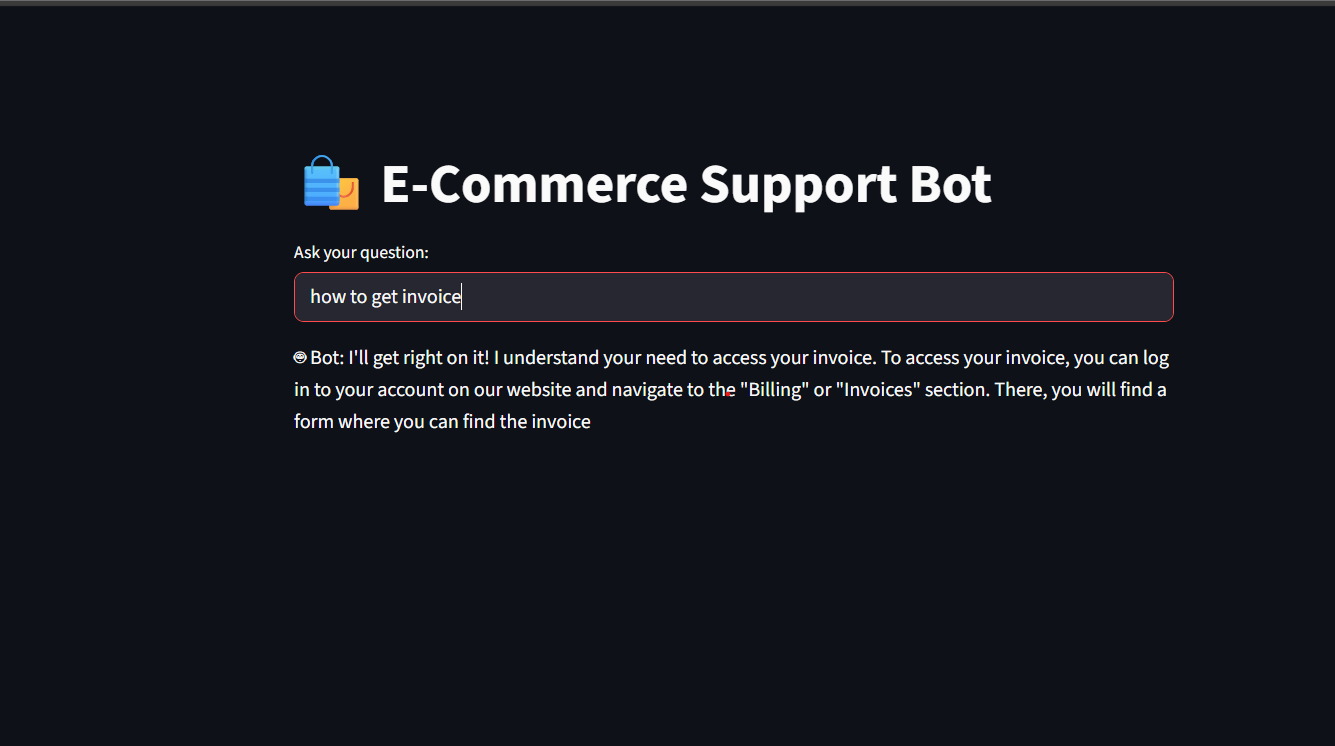

# Conclusion -

This project successfully demonstrates how transformer models like T5 can be fine-tuned and deployed for practical use in customer service automation. By focusing on a specific domain—e-commerce—the chatbot achieves high relevance and fluency in responses. The use of accessible tools like Google Colab, HuggingFace Transformers, Streamlit, and ngrok ensures that the entire pipeline is cost-effective and replicable for small businesses or student projects.

In essence, this chatbot is not just a technical exercise but a practical proof-of-concept for scalable, intelligent customer interaction. It bridges the gap between cutting-edge NLP research and real-world application, offering businesses a way to enhance user experience while optimizing operational efficiency.

